## BB-KI-CHIPS project 

Author: Hao Li

Address: Technical Univestiy of Munich, Big Geospatial Data Management, Lise-Meitner-Str. 9
85521 Ottobrunn;

Contact: hao_bgd.li@tum.de;

Copyright (c) 2022

In [225]:
# import the libraries you need

import os
import math
import numpy as np
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target
import shap
import tensorflow as tf

In [3]:
# define the functions you need

def loadimg(filename):
    # Open a single band and plot
    with rasterio.open(filename) as src:
        a = src.read()
        nbands = src.count
        nrows = src.height
        ncolumns = src.width
    image = np.empty([nrows, ncolumns, nbands])
    for i in range(nbands):
        image[:, :, i] = a[i, :, :]
    return image

## this function define how you split the raw image, in the example below is 64
def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        img.crop(box).save(out)

def visualize_patches(dir_tile, size):
    all_tiles=os.listdir(dir_tile)
    image_path = [os.path.join(dir_tile + "/" + i) for i in all_tiles]
    k=0
    total_num = size*size 
    for i in image_path[0:total_num]:
      k=k+1
      plt.subplot(size, size, k) 
      plt.imshow(imread(i))
      plt.axis('off')
    plt.show()

def std_image(src, eps=0.1):
    x_max = src.max()
    x_min = src.min()
    if x_max - x_min > eps:
        return 2 * ((src - x_min) / (x_max - x_min)) - 1
    return src    
    
def navie_sample(src_image, label):
    # forest-1, debris-2, water-3
    classes = label
    # get the feature space from drone image
    with rasterio.open(src_image) as src_ds:
        src = src_ds.read()
        std_src = std_image(src)
        yield (std_src, label)


# Input the drone data

['/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Selected Topics in Big Geospatial Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0708.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Selected Topics in Big Geospatial Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0682.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Selected Topics in Big Geospatial Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0684.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Selected Topics in Big Geospatial Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0686.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Selected Topics in Big Geospatial Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0700.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Selected Topics in Big Geospatial Data/BBKI_drone_debris_detect

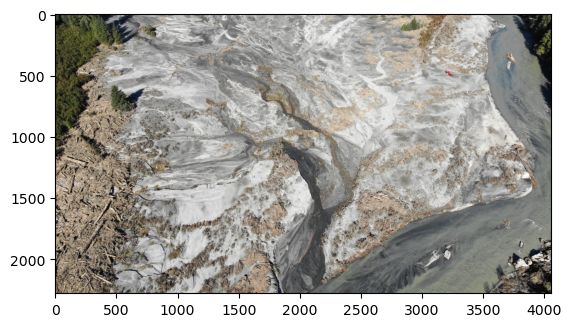

In [9]:
###########  Data Import #############

##You can also define your own path/name here
dir_image = r"/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Selected Topics in Big Geospatial Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data"
dir_tile = r"/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Selected Topics in Big Geospatial Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/tiles(0682)"


dir_image_JPG = dir_image + "/*.JPG"
raw_images = glob.glob(dir_image_JPG)
print(raw_images)

filenames = [os.path.basename(x) for x in glob.glob(dir_image_JPG)]

print(filenames)


###########  Visualize the first image #############
## Here you can show the image you are processing by changing the numbers 0,1,2,3 etc.
img = mpimg.imread(raw_images[1])
imgplot = plt.imshow(img)
plt.show()


## Preprocessing data step 1 - Tile the image

In [10]:
########### Tile image to pataches #############

# define the patch size,this way you would have 64*64 tiles. This can be changed at the -tile- funciton.
patch_size = 64

image = loadimg(raw_images[0])
pixel_x, pixel_y, bands= image.shape
print("Raw Images are of: " + str(pixel_x) + " x " + str(pixel_y) +" pixels")

tile(filenames[0], dir_image, dir_tile, patch_size)
print("Image tiling is now successful!")


/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Raw Images are of: 2280 x 4056 pixels
Image tiling is now successful!


### Labelling - step 1.5: if you want to directly try to work with the labelled data you can start from step 2


# Here the Labelling happens!! One should follow these steps:
--------------

### 1. Open the folder and check how many tiles are there: ./Ecstall_drone_data/Ecstall_drone_data/tiles

### 2. Check if there are three different sub-folders for classes:
    #### * debris
    #### * forest
    #### * water

### 3. Identify the corrrect classes for tiles and move them into the right sub-folder;

--------------

# As a results, each sub-folder should contains the right tiles for this classes.


## Preprocessing data step 2 - Visualize & sort the labelled data

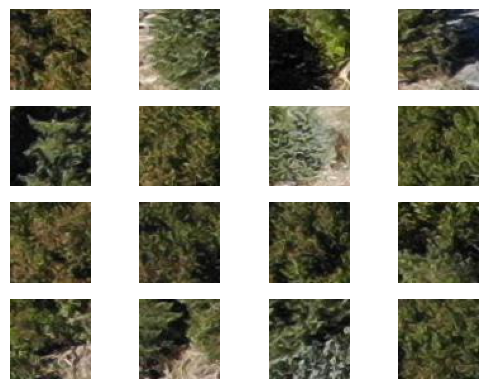

Example patches for forest


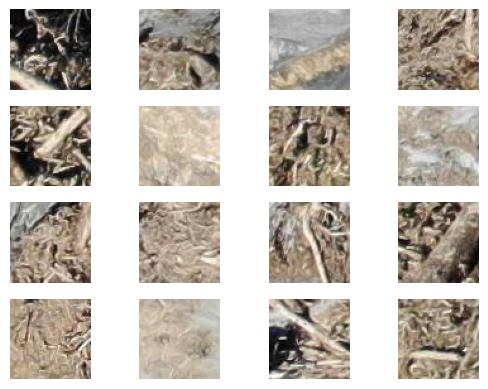

Example patches for debris


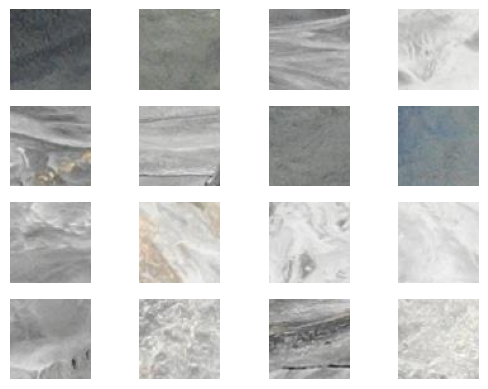

Example patches for water


In [11]:
########### Visualize 6x6 pataches for different classes #############

# with how many tile per row/colunm one want to visualize
# Here with the spcific example 0682, the white landcover mostly also been counted into the water class
visualize_size =  4

# class forest
dir_tile_forest = dir_tile + "/forest"
visualize_patches(dir_tile_forest, visualize_size)
print('Example patches for forest')

# class debris
dir_tile_debris = dir_tile + "/debris"
visualize_patches(dir_tile_debris, visualize_size)
print('Example patches for debris')

# class water

dir_tile_water = dir_tile + "/water"
visualize_patches(dir_tile_water, visualize_size)
print('Example patches for water')



## Preprocessing data step 3 - Store Image+Label for ML training 

In [12]:
########### define the result train/valid file #############
### Here the tiles are then saved into numpy arraies
root = r"/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Selected Topics in Big Geospatial Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/train_sample"

# training samples
t_forest = root + "forest_train_samples.npy"
t_debris = root + "debris_train_samples.npy"
t_water = root + "water_train_samples.npy"


# forest-1, save into numpy 
forest_tiles=os.listdir(dir_tile_forest)
t_sample = []
for p in tqdm(forest_tiles):
    image_path = dir_tile_forest + '/' + p
    result = list(navie_sample(image_path, 1))
    t_sample.append(result)
t_sample_array = np.array(t_sample, dtype=object)
#print(t_sample_array)
np.save(t_forest, t_sample_array)


# debris-2, save into numpy (someone need to rewrite it with a loop)
debris_tiles=os.listdir(dir_tile_debris)
t_sample = []
for p in tqdm(debris_tiles):
    image_path = dir_tile_debris + '/' + p
    result = list(navie_sample(image_path, 2))
    t_sample.append(result)
t_sample_array = np.array(t_sample, dtype=object)
#print(t_sample_array)
np.save(t_debris, t_sample_array)


# water-3, save into numpy 
water_tiles=os.listdir(dir_tile_water)
t_sample = []
for p in tqdm(water_tiles):
    image_path = dir_tile_water + '/' + p
    result = list(navie_sample(image_path, 3))
    t_sample.append(result)
t_sample_array = np.array(t_sample, dtype=object)
#print(t_sample_array)
np.save(t_water, t_sample_array)


#print("All training data is saved into: " + root)


    

100%|██████████| 828/828 [00:01<00:00, 629.31it/s]


## Preprocessing data step 4 - Split into train and val

In [13]:
# get all npy files
## The ratio can also be changed
split_ratio = 0.8
dir_samples = root + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = root + "/train_merge.npy"
v_samples_merge_path = root + "/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 26.55it/s]


Now all merge samples are saved!


In [14]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)


(3309, 1, 2)
(828, 1, 2)


In [15]:
train_merge=np.array(train_merge)

print(train_merge[0,0,1])
print(train_merge[0,0,0].shape)



2
(3, 64, 64)


## Preprocessing data step 5 -  Random Forest Classifier

Machine learning: A computer program is said to learn from experience E with respect to some task T and some performance measure P, if its performance on T, as measured by P, improves with experience E (*Tom M. Michell, 1997*).


A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.



In [16]:
# The random forest expects a vector of features. Therefore,
# we concatenate all bands and pixels
UAV_train = train_merge[:,:,0]
number_samples = UAV_train.shape[0]
Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)


X_train= np.zeros((number_samples,  3 * 64 * 64), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = np.reshape(UAV_train[i,0], (1, 3 * 64 * 64))
    

print("Post-processed UAV data shape: ", X_train.shape)
print("Post-processed class type data shape: ", Y_train.shape)


Post-processed UAV data shape:  (3309, 12288)
Post-processed class type data shape:  (3309,)


In [17]:
UAV_val = val_merge[:,:,0]

number_samples = UAV_val.shape[0]
Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

X_val= np.zeros((number_samples,  3 * 64 * 64), dtype=float)
for i in range(0,number_samples-1):
    X_val[i,:] = np.reshape(UAV_val[i,0], (1, 3 * 64 * 64))
    

print("Post-processed UAV data shape: ", X_val.shape)
print("Post-processed class type data shape: ", Y_val.shape)

Post-processed UAV data shape:  (828, 12288)
Post-processed class type data shape:  (828,)


In [18]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

In [19]:
y_pred_rf = rf_classifier.predict(X_val)

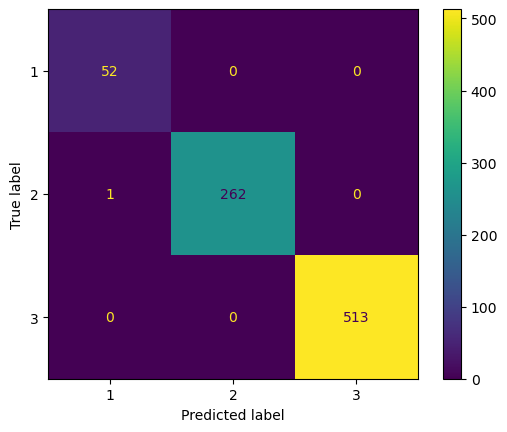

Accuracy Random Forest Classifier:  0.998792270531401


In [20]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

## Preprocessing data step 6 -  Deep learning: Artificial neural network

The human brain is a *machine* capable of performing very complex tasks, such as pattern recognition, motor control of a limb or perception of sensory stimuli, much faster than any machine invented by man. For this reason, great efforts have been (and continue to be) made to understand how they work. 

Machine learning: A computer program is said to learn from experience E with respect to some task T and some performance measure P, if its performance on T, as measured by P, improves with experience E (*Tom M. Michell, 1997*).


In [190]:
number_samples = UAV_train.shape[0]
Z_train= np.zeros((number_samples,  3 , 64 ,64), dtype=float)
for i in range(0,number_samples-1):
    Z_train[i,:] = UAV_train[i,0]
    

print("Post-processed UAV data shape: ", Z_train.shape)
print("Post-processed class type data shape: ", Y_train.shape)

Post-processed UAV data shape:  (3309, 3, 64, 64)
Post-processed class type data shape:  (3309,)


In [191]:
number_samples = UAV_val.shape[0]
Z_val= np.zeros((number_samples,  3 , 64 ,64), dtype=float)
for i in range(0,number_samples-1):
    Z_val[i,:] = UAV_val[i,0]
    

print("Post-processed UAV data shape: ", Z_val.shape)
print("Post-processed class type data shape: ", Y_val.shape)

Post-processed UAV data shape:  (828, 3, 64, 64)
Post-processed class type data shape:  (828,)


In [199]:
number_samples = UAV_train.shape[0]
R_trai= np.zeros((number_samples, 3, 64 ,64), dtype=float)
R_train= np.zeros((number_samples,  64 ,64,3), dtype=float)

for i in range(0,number_samples-1):
    R_trai[i,:] = UAV_train[i,0]
    R_train[i,:] = np.stack((R_trai[i,0,:],R_trai[i,1,:],R_trai[i,2,:]),axis=2)
    
print("Post-processed UAV data shape: ", R_train.shape)
print("Post-processed class type data shape: ", Y_train.shape)

Post-processed UAV data shape:  (3309, 64, 64, 3)
Post-processed class type data shape:  (3309,)


In [200]:
number_samples = UAV_val.shape[0]
R_va= np.zeros((number_samples, 3, 64 ,64), dtype=float)
R_val= np.zeros((number_samples,  64 ,64,3), dtype=float)

for i in range(0,number_samples-1):
    R_va[i,:] = UAV_val[i,0]
    R_val[i,:] = np.stack((R_va[i,0,:],R_va[i,1,:],R_va[i,2,:]),axis=2)
    
print("Post-processed UAV data shape: ", R_val.shape)
print("Post-processed class type data shape: ", Y_val.shape)

Post-processed UAV data shape:  (828, 64, 64, 3)
Post-processed class type data shape:  (828,)


In [192]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3, 64, 64)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [193]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [194]:
history=simple_model.fit(Z_train, Y_train, epochs=200,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=50)],  verbose=0,validation_data=(Z_val, Y_val))


Epoch 1/200


2023-01-13 02:44:25.454668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-13 02:44:26.911377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 2s 19ms/sample - loss: 0.8279 - accuracy: 0.8401 - val_loss: 1.0914 - val_accuracy: 0.8744
Epoch 51/200
104/104 [==============================] - 1s 8ms/sample - loss: 7.3937e-04 - accuracy: 0.9997 - val_loss: 0.0049 - val_accuracy: 0.9988
Epoch 101/200
104/104 [==============================] - 1s 7ms/sample - loss: 5.0568e-04 - accuracy: 0.9997 - val_loss: 0.0027 - val_accuracy: 0.9988
Epoch 151/200
104/104 [==============================] - 1s 7ms/sample - loss: 3.7256e-04 - accuracy: 0.9997 - val_loss: 0.0027 - val_accuracy: 0.9988


26/26 [==============================] - 0s 7ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction example:  [0.0000000e+00 1.0000000e+00 2.2994032e-27 9.0625423e-21 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]  Class:  1
Prediction example:  [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2058899e-36
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]  Class:  2
Prediction example:  [0.0000000e+00 0.0000000e+00 1.3232987e-32 1.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]  Class:  3


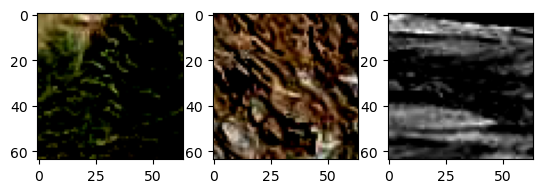

In [218]:
y_pred_dl_p = simple_model.predict(Z_val)
plt.subplot(1, 3, 1) 
plt.imshow(R_val[25,:])
plt.subplot(1, 3, 2) 
plt.imshow(R_val[5,:])
plt.subplot(1, 3, 3) 
plt.imshow(R_val[1,:])
print("Prediction example: ", y_pred_dl_p[25,:], " Class: ", np.argmax(y_pred_dl_p[25,:]))
print("Prediction example: ", y_pred_dl_p[5,:], " Class: ", np.argmax(y_pred_dl_p[5,:]))
print("Prediction example: ", y_pred_dl_p[1,:], " Class: ", np.argmax(y_pred_dl_p[1,:]))

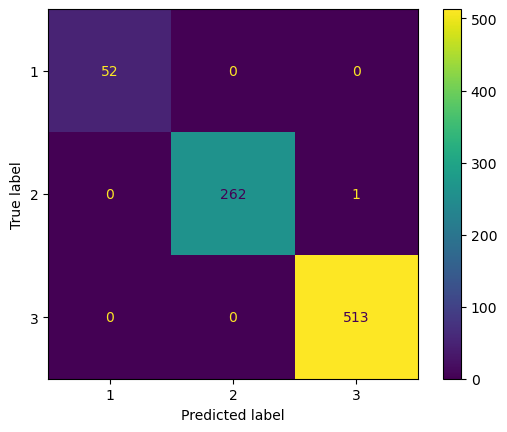

Accuracy Simple Deep Learning model:  0.998792270531401


In [219]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

2023-01-13 03:00:41.985624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 - 1s - loss: 0.0029 - accuracy: 0.9988 - 562ms/epoch - 22ms/step
0.9987922310829163


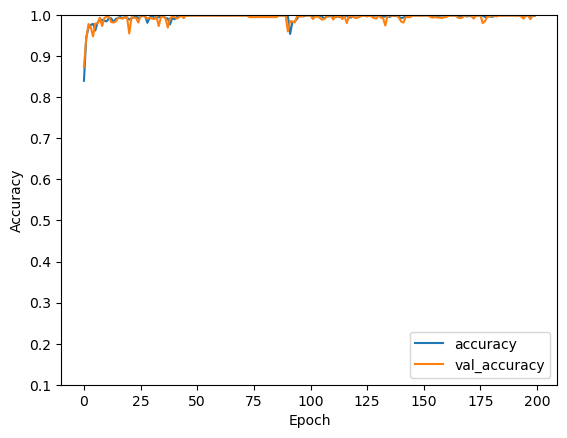

In [220]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Preprocessing data step 7 - Residual Network: ResNet

A residual neural network (ResNet) is an artificial neural network that imitate the pyramidal cells in the cerebral cortex. Particularly, the ResNet architecture consists of skip connections or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. These *cells* are known as *residual block*.

ResNets connection weights are easier to optimize (especially for gradient descent-based optimizers) because the short cuts contribute to alleviate the vanishing gradient problem.

In practice, the degradation problem (i.e., increasing the depth of a network leads to a decrease in its performance) is mitigated, and the observed performance (when the number of hidden layers increase) is much closer to the theoretical one.


In [239]:
model_rn = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=( 64, 64,3), 
    pooling=None,
    classes=16)

model_rn.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

# Uncomment the following line to check the full model
# model_rn.summary()

In [242]:

history=model_rn.fit(R_train, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,validation_data=(R_val, Y_val))


Epoch 1/100


2023-01-13 04:23:28.298075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-13 04:23:48.581399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 27s 258ms/sample - loss: 0.5079 - accuracy: 0.8873 - val_loss: 2.5443 - val_accuracy: 0.6196
Epoch 21/100
104/104 [==============================] - 10s 96ms/sample - loss: 0.0352 - accuracy: 0.9891 - val_loss: 0.0329 - val_accuracy: 0.9915
Epoch 41/100
104/104 [==============================] - 10s 93ms/sample - loss: 0.1057 - accuracy: 0.9701 - val_loss: 0.9549 - val_accuracy: 0.9662
Epoch 61/100
104/104 [==============================] - 10s 93ms/sample - loss: 0.0151 - accuracy: 0.9958 - val_loss: 0.0139 - val_accuracy: 0.9964
Epoch 81/100
104/104 [==============================] - 9s 91ms/sample - loss: 0.0103 - accuracy: 0.9973 - val_loss: 0.0068 - val_accuracy: 0.9988


2023-01-13 04:39:47.561684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 5s 107ms/step


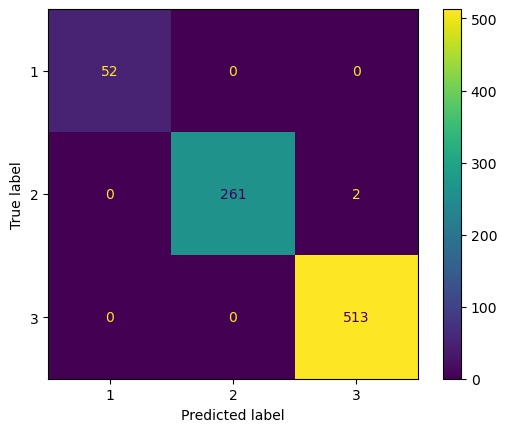

Accuracy ResNet-50 model:  0.9975845410628019


In [243]:
y_pred_rn_p = model_rn.predict(R_val)

y_pred_rn = np.argmax(y_pred_rn_p, axis=1)

##print(y_pred_rn)
#print(Y_val)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rn)
plt.show()

acc_rn = accuracy_score(Y_val, y_pred_rn)
print("Accuracy ResNet-50 model: ", acc_rn)

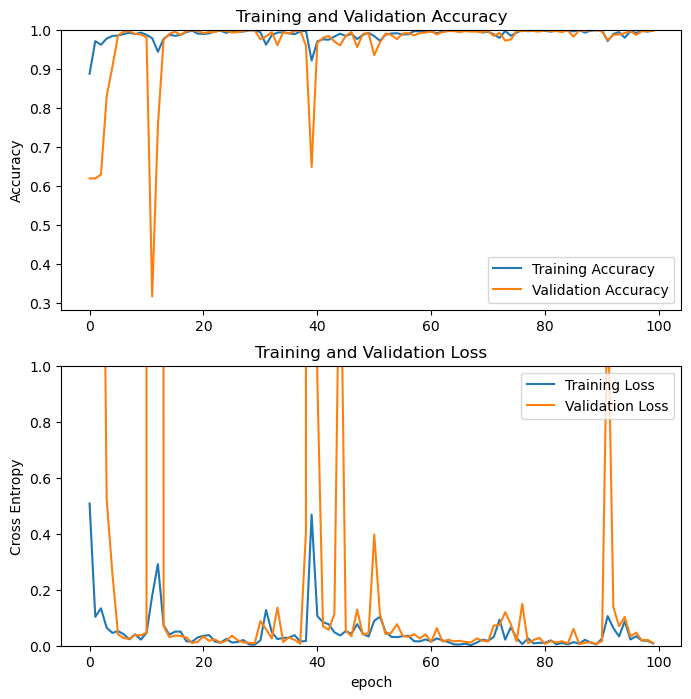

In [245]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Preprocessing data step 8 - Convolutional Network: CNN

In [231]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu",input_shape=( 64, 64,3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
]
)

In [232]:

model.summary() 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 16384)             0         
                                                                 
 dense_22 (Dense)            (None, 64)               

In [233]:

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16))

In [234]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 16384)             0         
                                                                 
 dense_22 (Dense)            (None, 64)               

In [235]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(R_train, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,
                    validation_data=(R_val, Y_val))

Epoch 1/100


2023-01-13 04:17:59.932644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-13 04:18:03.639599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 5s 45ms/sample - loss: 0.3544 - accuracy: 0.8785 - val_loss: 0.1350 - val_accuracy: 0.9734
Epoch 21/100
104/104 [==============================] - 2s 23ms/sample - loss: 1.5678e-04 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9988
Epoch 41/100
104/104 [==============================] - 2s 22ms/sample - loss: 5.8703e-06 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9988
Epoch 61/100
104/104 [==============================] - 2s 23ms/sample - loss: 1.4434e-06 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 0.9988
Epoch 81/100
104/104 [==============================] - 2s 22ms/sample - loss: 4.2573e-07 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 0.9988


In [236]:
y_pred_cnn_p = model.predict(R_val)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

 1/26 [>.............................] - ETA: 4s

2023-01-13 04:22:13.442119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 16ms/step
Prediction example:  [-51.939503   20.454428   24.1872     58.76603    10.524406  -22.387093
   5.2913694 -38.94667   -25.063734   -9.3634815 -30.567326  -38.91276
 -19.042421  -33.99519    -1.5610095 -22.75706  ]  Class:  3


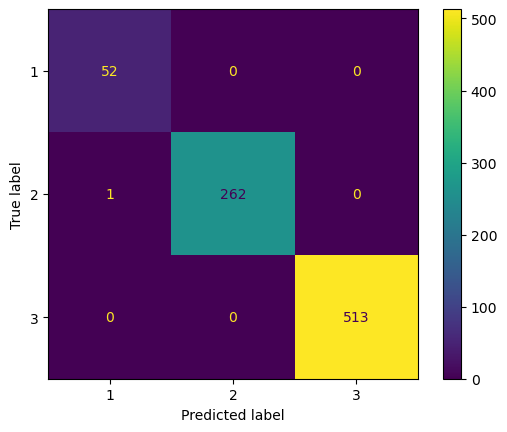

Accuracy Simple Deep Learning model:  0.998792270531401


In [237]:
y_pred_cnn = np.array(np.argmax(y_pred_cnn_p, axis=1)).astype(int)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

26/26 - 0s - loss: 0.0176 - accuracy: 0.9988 - 418ms/epoch - 16ms/step
0.9987922310829163


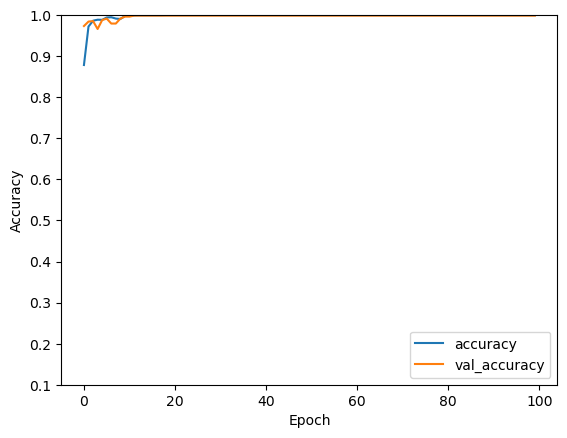

In [238]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()